# Bài thực hành: Unsupervised Domain Adaptation

In [1]:
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from PIL import Image
import os
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

# Tạo dataloader

In [2]:
class GetLoader(torch.utils.data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

# Tạo lớp reverse layer
Thêm hệ số $\alpha$ vào reversed gradient

In [3]:
from torch.autograd import Function

class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

# Mô hình chính
Tương tự mô hình CNN bình thường nhưng thêm bộ phân loại miền dữ liệu:
- Bộ trích xuất đặc trưng: $G_f$
- Bộ phân loại nhãn của dữ liệu nguồn: $G_y$
- Bộ phân loại miền dữ liệu (nguồn hay đích): $G_d$

In [4]:
import torch.nn as nn

class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()

        # Đây là phần feature extracter (encoder/backbone)
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        # Xây dựng bộ phân lớp chữ số gồm các lớp sau với số lượng tham số như summary phía dưới
        # FC 100 -> BN -> ReLU -> Dropout -> FC 100 -> BN -> ReLU -> FC 10 -> LogSoftmax
        self.class_classifier = nn.Sequential(
            nn.Linear(50*4*4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100,10),
            nn.LogSoftmax(dim=1)
        )


        # Xây dựng bộ phân lớp miền gồm các lớp sau với số lượng tham số như summary phía dưới
        # FC 100 -> BN -> ReLU -> FC 2 -> LogSoftmax
        self.domain_classifier = nn.Sequential(
            nn.Linear(50*4*4, 100 ),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, input_data, alpha=0):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature) ### YOUR CODE HERE ###
        domain_output = self.domain_classifier(reverse_feature) ### YOUR CODE HERE ###

        return class_output, domain_output

D = CNNModel().cuda()
summary(D, [(3,28,28)], batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           4,864
       BatchNorm2d-2           [-1, 64, 24, 24]             128
         MaxPool2d-3           [-1, 64, 12, 12]               0
              ReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 50, 8, 8]          80,050
       BatchNorm2d-6             [-1, 50, 8, 8]             100
         Dropout2d-7             [-1, 50, 8, 8]               0
         MaxPool2d-8             [-1, 50, 4, 4]               0
              ReLU-9             [-1, 50, 4, 4]               0
           Linear-10                  [-1, 100]          80,100
      BatchNorm1d-11                  [-1, 100]             200
             ReLU-12                  [-1, 100]               0
          Dropout-13                  [-1, 100]               0
           Linear-14                  [

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tải và trực quan hoá dữ liệu


## Đầu tiên chúng ta tải dữ liệu MNIST và MNISTM:

In [6]:

!curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id=0B_tExHiYS-0veklUZHFYT19KYjg'| sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
!curl -L -b cookies.txt -o mnist_m.tar 'https://docs.google.com/uc?export=download&id=0B_tExHiYS-0veklUZHFYT19KYjg&confirm='$(<confirm.txt)
#!wget http://112.78.4.106/mnist_m.tar.gz
!rm -f confirm.txt cookies.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2416  100  2416    0     0  11300      0 --:--:-- --:--:-- --:--:-- 11300
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2416  100  2416    0     0  11752      0 --:--:-- --:--:-- --:--:-- 29827


In [ ]:
#backup link

!curl -L -c cookies.txt 'https://drive.google.com/uc?export=download&id=1YHGhEQVEJ9glB-KfMdvztVVZ-cMLrxOU'| sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
!curl -L -b cookies.txt -o mnist_m.tar.gz 'https://drive.google.com/uc?export=download&id=1YHGhEQVEJ9glB-KfMdvztVVZ-cMLrxOU&confirm='$(<confirm.txt)
!rm -f confirm.txt cookies.txt

# Có thể tải từ link và up lên gg colab

In [9]:
#!mkdir -p dataset
#!mkdir -p models
!mv mnist_m.tar.gz dataset
%cd dataset
!tar -xvf /content/dataset/mnist_m.tar.gz > /dev/null

/content/dataset


In [11]:
%cd ..

/content


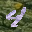

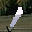

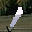

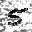

In [12]:
from IPython.display import Image, display

list_imgs = ['dataset/mnist_m/mnist_m_test/00008264.png', 'dataset/mnist_m/mnist_m_test/00005093.png',
            'dataset/mnist_m/mnist_m_test/00005093.png', 'dataset/mnist_m/mnist_m_test/00005222.png']

for img_name in list_imgs:
    display(Image(filename=img_name))

In [13]:
from PIL import Image

source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
target_image_root = os.path.join('dataset', target_dataset_name)
model_root = 'models'
cuda = True
cudnn.benchmark = True
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 100

try:
    num_workers = int(os.popen('nproc').read())
except:
    num_workers = 4

manual_seed = random.randint(1, 10000)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
# load data

img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset_source = datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

dataloader_source = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')
dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

dataloader_target = torch.utils.data.DataLoader(
    dataset=dataset_target,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)


100%|██████████| 9912422/9912422 [00:00<00:00, 117118308.58it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63488309.13it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31505037.86it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19518984.39it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
dataset_source[0]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

# Tạo một đối tượng model cụ thể và optimizer

In [15]:

my_net = CNNModel()### YOUR CODE HERE ###

# Khai báo optimizer Adam với tốc độ học là lr
lr = 0.001
optimizer = optim.Adam(my_net.parameters(), lr=lr)### YOUR CODE HERE ###

# Khai báo hàm loss Negative log likelihood
loss_class = nn.NLLLoss()### YOUR CODE HERE ###
loss_domain = nn.CrossEntropyLoss()### YOUR CODE HERE ###

if cuda:
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()
    loss_domain = loss_domain.cuda()

for p in my_net.parameters():
    p.requires_grad = True


# Hàm test

In [19]:

def test(dataset_name, epoch):
    assert dataset_name in ['MNIST', 'mnist_m']

    model_root = 'models'
    image_root = os.path.join('dataset', dataset_name)

    cuda = True
    cudnn.benchmark = True
    batch_size = 128
    image_size = 28
    alpha = 0

    """load data"""

    img_transform_source = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

    img_transform_target = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

    if dataset_name == 'mnist_m':
        test_list = os.path.join(image_root, 'mnist_m_test_labels.txt')

        dataset = GetLoader(
            data_root=os.path.join(image_root, 'mnist_m_test'),
            data_list=test_list,
            transform=img_transform_target
        )
    else:
        dataset = datasets.MNIST(
            root='dataset',
            train=False,
            transform=img_transform_source,
        )

    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8
    )

    """ training """

    my_net = torch.load(os.path.join(
        model_root, 'mnist_mnistm_model_epoch_' + str(epoch) + '.pth'
    ))
    my_net = my_net.eval()

    if cuda:
        my_net = my_net.cuda()

    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0

    while i < len_dataloader:

        # test model using target data
        data_target = next(data_target_iter)
        t_img, t_label = data_target

        batch_size = len(t_label)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)

        if cuda:
            t_img = t_img.cuda()
            t_label = t_label.cuda()
            input_img = input_img.cuda()
            class_label = class_label.cuda()

        input_img.resize_as_(t_img).copy_(t_img)
        class_label.resize_as_(t_label).copy_(t_label)

        class_output, _ = my_net(input_data=input_img, alpha=alpha)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

        i += 1

    accu = n_correct.data.numpy() * 1.0 / n_total

    print('epoch: %d, accuracy of the %s dataset: %f' % (epoch, dataset_name, accu))

# Huấn luyện mô hình

In [20]:
import numpy as np


for epoch in range(n_epoch):

    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)

    i = 0
    while i < len_dataloader:

        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # training model using source data
        data_source = next(data_source_iter)
        s_img, s_label = data_source

        my_net.zero_grad()
        batch_size = len(s_label)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()

        if cuda:
            s_img = s_img.cuda()
            s_label = s_label.cuda()
            input_img = input_img.cuda()
            class_label = class_label.cuda()
            domain_label = domain_label.cuda()

        input_img.resize_as_(s_img).copy_(s_img)
        class_label.resize_as_(s_label).copy_(s_label)

        class_output, domain_output = my_net(input_data=input_img, alpha=alpha)

        # Tính toán hàm loss bằng cách so sánh class_output, domain_output với class_label và domain_label
        err_s_label = loss_class(class_output, class_label)### YOUR CODE HERE ###
        err_s_domain = loss_domain(domain_output, domain_label)### YOUR CODE HERE ###

        # training model using target data
        data_target = next(data_target_iter)
        t_img, _ = data_target

        batch_size = len(t_img)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()

        if cuda:
            t_img = t_img.cuda()
            input_img = input_img.cuda()
            domain_label = domain_label.cuda()

        input_img.resize_as_(t_img).copy_(t_img)

        _, domain_output = my_net(input_data=input_img, alpha=alpha)

        # Khi dùng target domain ta không có nhãn phân lớp chữ số nên chỉ có loss phân lớp 2 miền nguồn/đích
        err_t_domain = loss_domain(domain_output, domain_label)### YOUR CODE HERE ###

        # Loss chung cả mô hình là kết hợp các loss trên
        err = err_s_label + err_s_domain + err_t_domain ### YOUR CODE HERE ###

        err.backward()
        optimizer.step()

        i += 1

        print('epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
              % (epoch, i, len_dataloader, err_s_label.cpu().data.numpy(),
                 err_s_domain.cpu().data.numpy(), err_t_domain.cpu().data.numpy()))

    torch.save(my_net, '{0}/mnist_mnistm_model_epoch_{1}.pth'.format(model_root, epoch))
    test(source_dataset_name, epoch)
    test(target_dataset_name, epoch)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Streaming output truncated to the last 5000 lines.
epoch: 9, [iter: 93 / all 461], err_s_label: 0.137770, err_s_domain: 0.661180, err_t_domain: 0.616429
epoch: 9, [iter: 94 / all 461], err_s_label: 0.144285, err_s_domain: 0.606329, err_t_domain: 0.552776
epoch: 9, [iter: 95 / all 461], err_s_label: 0.221305, err_s_domain: 0.591952, err_t_domain: 0.579186
epoch: 9, [iter: 96 / all 461], err_s_label: 0.095671, err_s_domain: 0.611905, err_t_domain: 0.663806
epoch: 9, [iter: 97 / all 461], err_s_label: 0.145855, err_s_domain: 0.560225, err_t_domain: 0.633675
epoch: 9, [iter: 98 / all 461], err_s_label: 0.202262, err_s_domain: 0.607232, err_t_domain: 0.651304
epoch: 9, [iter: 99 / all 461], err_s_label: 0.173445, err_s_domain: 0.573749, err_t_domain: 0.625559
epoch: 9, [iter: 100 / all 461], err_s_label: 0.107762, err_s_domain: 0.568195, err_t_domain: 0.594032
epoch: 9, [iter: 101 / all 461], err_s_label: 0.158457, err_s_domain: 0.639843, err_t_domain: 0.599296
epoch: 9, [iter: 102 / all 46

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78ebad35f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78ebad35f6d0>    Exception ignored in: Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x78ebad35f6d0>

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78ebad35f6d0>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
    asse

Streaming output truncated to the last 5000 lines.
epoch: 43, [iter: 118 / all 461], err_s_label: 0.080932, err_s_domain: 0.656560, err_t_domain: 0.613076
epoch: 43, [iter: 119 / all 461], err_s_label: 0.194219, err_s_domain: 0.662438, err_t_domain: 0.622450
epoch: 43, [iter: 120 / all 461], err_s_label: 0.093228, err_s_domain: 0.642449, err_t_domain: 0.656678
epoch: 43, [iter: 121 / all 461], err_s_label: 0.150175, err_s_domain: 0.665798, err_t_domain: 0.646393
epoch: 43, [iter: 122 / all 461], err_s_label: 0.052560, err_s_domain: 0.669920, err_t_domain: 0.637087
epoch: 43, [iter: 123 / all 461], err_s_label: 0.191778, err_s_domain: 0.608402, err_t_domain: 0.673693
epoch: 43, [iter: 124 / all 461], err_s_label: 0.189122, err_s_domain: 0.628138, err_t_domain: 0.673898
epoch: 43, [iter: 125 / all 461], err_s_label: 0.189645, err_s_domain: 0.679368, err_t_domain: 0.730606
epoch: 43, [iter: 126 / all 461], err_s_label: 0.046612, err_s_domain: 0.595456, err_t_domain: 0.601730
epoch: 43, [i

KeyboardInterrupt: 

In [ ]:
def predict(model, dataloader):
    model.eval()
    predictions = []

    for data in dataloader:
        images, _ = data

        if cuda:
            images = images.cuda()

        outputs, _ = model(input_data=images, alpha=alpha)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

    return predictions

# Load the trained model
model_path = 'models/mnist_mnistm_model_epoch_{}.pth'.format(epoch)
my_net = torch.load(model_path)
my_net = my_net.eval()

# Create dataloader for the test dataset
test_dataset = GetLoader(data_root='/content/dataset/mnist_m/mnist_m_test', data_list='/content/dataset/mnist_m/mnist_m_test_labels.txt', transform=img_transform_target)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Use the predict function to get predictions
predictions = predict(my_net, test_dataloader)

# Print the predictions
print(predictions)

FileNotFoundError: [Errno 2] No such file or directory: 'models/mnist_mnistm_model_epoch_54.pth'